---
layout: post
title: Imputation with fancyimpute and missingno
---

Missing data is an unfortunate reality of data science. The models that we use do not play well with missing data. Early in the career of a data scientist the usual way of dealing with missing data is to simply remove rows or columns that contain missing values. The side effect of this is that knowledge that can be used by our models disappears affecting our predictions and adding variance to our models. 

To correct this we as Data Scientists will attempt to impute missing data. The first method usually used is through simple imputation. Replacing the missing values usually with the Mean or Median value of the column. This method will allow us to run our models and preserve the mean or median but it has serious consequences. The standard deviation will be reduced as well as having a large spike in the value count of the mean and median. This method simply changes the number of issues we are presented with in from missing data to inaccurate data. 

The second method of imputation is imputation by deduction. We attempt to solve a question of missing data by using other factors in the dataset to get a reasonable, if not completely accurate, guess. For example, one can reasonably argue that a house listed as having no basement but a missing value for basement square footage could have the value zero imputed to replace the missing value. We cannot be certain that the error is not in the entire row but if this pattern is displayed throughout the dataset and we assume our data is accurate it is a reasonable assumption to make. The issue is that this method is possible, if time consuming, on a small dataset it quickly becomes an insurmountable task on larger datasets. 

The final method of imputation that we will discuss is imputation by model. In the R language the common package to use for imputation is MICE but this is not available in Python. Instead, the package that we will use is called fancyimpute. We will be using fancyimpute to perform a simple imputation as well as some of the other models of imputation on the Titanic dataset. As well as using the missingno package to explore our missing data. 

| Variable | Definition                                 | Key                                                                                                                                                                                                |
|----------|--------------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| survival | Survival                                   | 0 = No, 1 = Yes                                                                                                                                                                                    |
| pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd  pclass : A proxy for socio-economic status (SES)  1st = Upper  2nd = Middle  3rd = Lower                                                                                |
| sex      | Sex                                        |                                                                                                                                                                                                    |
| Age      | Age in years                               | Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5                                                                                                               |
| sibsp    | # of siblings / spouses aboard the Titanic | The dataset defines family relations in this way...  Sibling = brother, sister, stepbrother, stepsister  Spouse = husband, wife (mistresses and fiancés were ignored)                              |
| parch    | # of parents / children aboard the Titanic | The dataset defines family relations in this way...  Parent = mother, father  Child = daughter, son, stepdaughter, stepson  Some children travelled only with a nanny, therefore parch=0 for them. |
| ticket   | Ticket number                              |                                                                                                                                                                                                    |
| fare     | Passenger fare                             |                                                                                                                                                                                                    |
| cabin    | Cabin number                               |                                                                                                                                                                                                    |
| embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton                                                                                                                                                     |

The first thing that we are going to do is to import all our packages. To test our results we are going to use a Random Forest and compare our results with a confusion matrix.

In [2]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [9]:
sns.set(style="darkgrid")
sns.set(style="darkgrid")

In [10]:
df_train = pd.read_csv('./data/train.csv')

The first real use of code is displaying the relationship of our missing data with missingno in a dendrogram followed by a bar graph. The dendrogram dosen't give us much information but the bar graph shows that we are missing about 20% of our data from the Age column and 80% of our data from the test column.

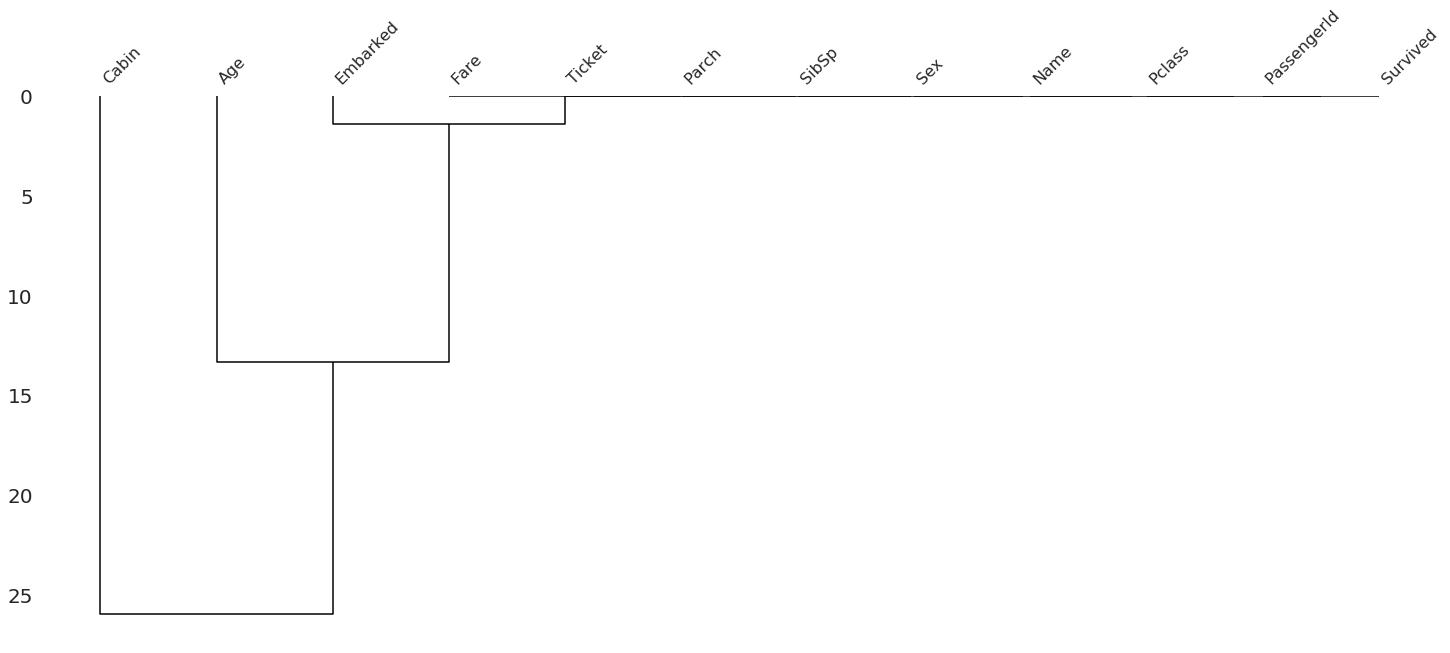

In [12]:
msno.dendrogram(df_train);

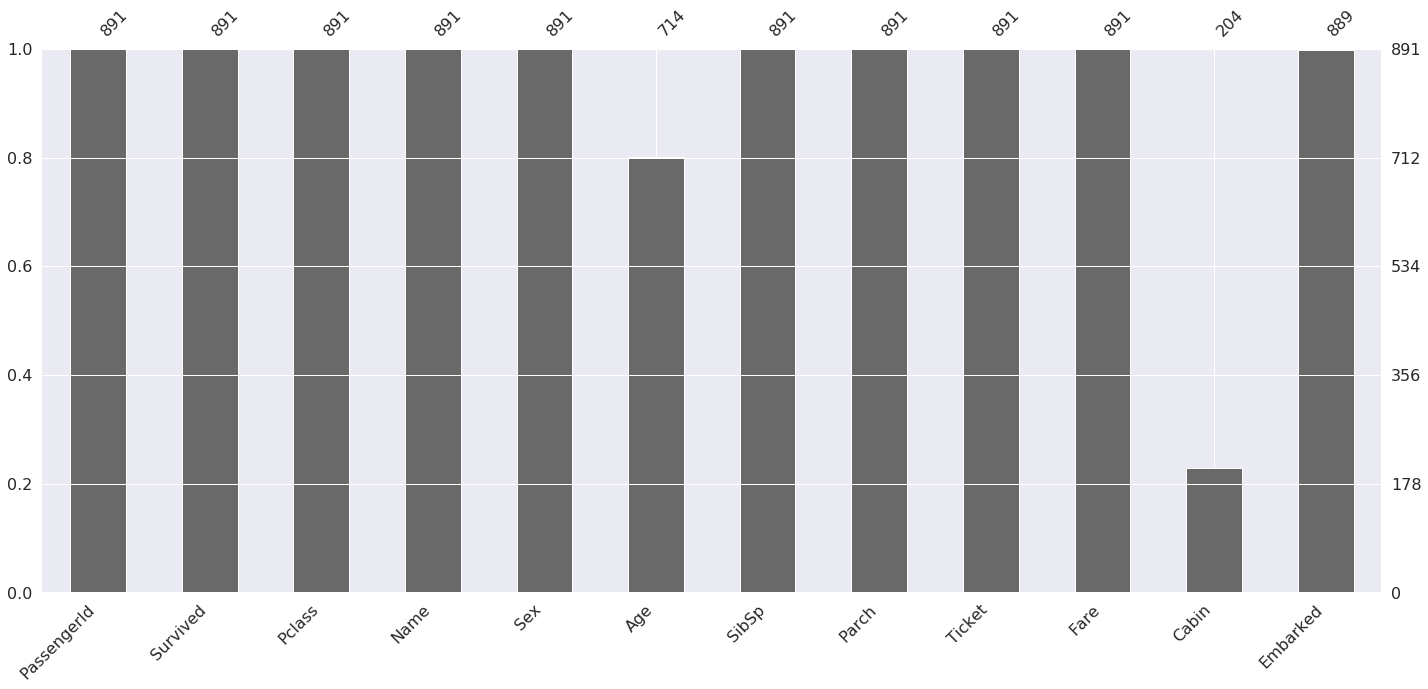

In [13]:
msno.bar(df_train);

The Embarked column has two missing values. This represents 0.22% of our data. While it is possible to perform deductive imputation the best course is to simply drop the value and maintain the integrity of our data.

In [16]:
df_train.dropna(subset=['Embarked'],inplace=True)

The problem with the Cabin column is the opposite. Only 19% of the data is valid in the test dataframe and 23% is valid in the train dataframe. The simple solution here is to drop the entire column. A slightly more complex solution is to create a new column that lists if we know the cabin value as a simple binary and eliminate the original column. We could then see if there is any correlation with our target variable. Because this is a post on imputation and not Titanic I'm going to use the simple method and drop the column.

In [17]:
df_train.drop('Cabin', axis=1, inplace=True)

The Age column is the most interesting. The dataset have about 80% of the data intact. This is enough to attempt to make valid guesses with the data to attempt to impute the missing values. 

I think that now would be a good time to segue into the different types of missing data. First, there is NMAR data that is not missing at random. This is not something that can be corrected with imputation and can only be dealt with in the data collection phase. We are going to assume that our data is not NMAR.

The next two types of missing data are MAR, Missing at Random, and MCAR, Missing completely at random. These two sound similar but there are significant differences. With MCAR the missing data is not correlated with any of the observed data. This means that we can safely drop these values without it affecting the model much. MAR has missing data that is correlated with observed data. With this knowledge we can use different models, such as those found in fancyimpute to attempt to impute the data. 

From the matrix graph in missingno we see that the missing data in the Age column appears to be randomly distributed throughout the column. There are a few test to see if a dataset has MCAR or MAR but I have not found a good package to preform these test automatically. 

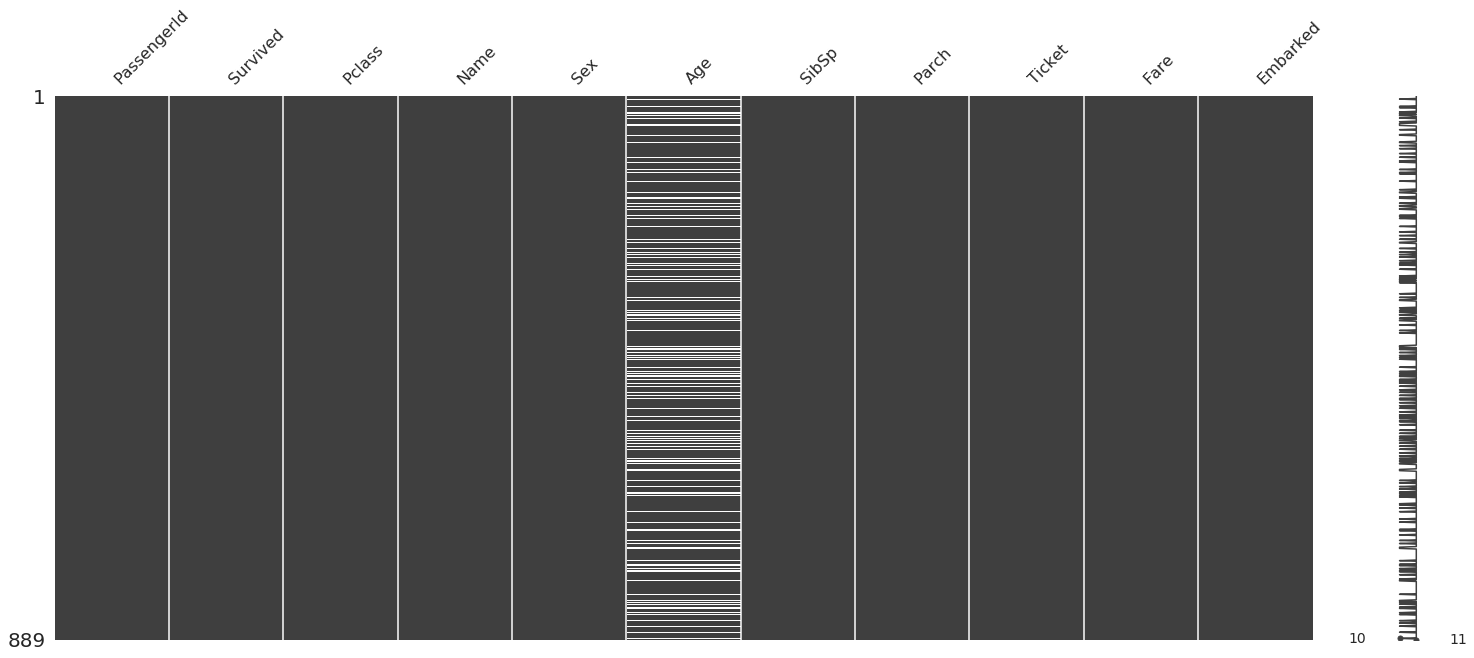

In [18]:
msno.matrix(df_train);

To check the type of missing data we will see if the variables we have are randomly distributed evenly between a dataset that has all values for age missing and a dataset that has all values filled. If both sets are approximately equal then we have MCAR. If not then we have MAR and can use imputation.

Let's create a new column to see if we have an age value and then run the data through seaborn to look at our data.

In [31]:
df_train.Age.fillna(0,inplace=True)
df_train['known_age']= np.where(df_train.Age==0,False,True)

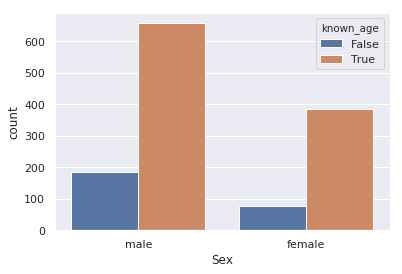

In [35]:
sns.set(style="darkgrid")
ax =sns.countplot(x = 'Sex', hue = 'known_age',data = df_graph, orient='v')
#ax =sns.countplot(x = 'Embarked', hue = 'known_age',data = df_graph, orient='v')

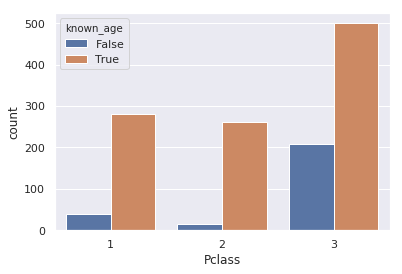

In [36]:
sns.set(style="darkgrid")
ax =sns.countplot(x = 'Pclass', hue = 'known_age',data = df_graph, orient='v')

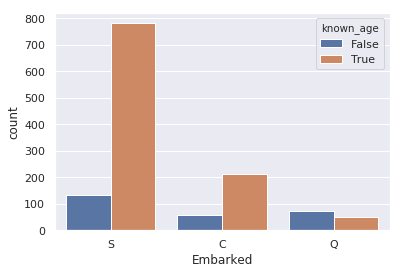

In [38]:
sns.set(style="darkgrid")
ax =sns.countplot(x = 'Embarked', hue = 'known_age',data = df_graph, orient='v')

Based on the above graphs the missing data does not appear to be completely random. In fact it appears to be strongly correlated with the values in Pclass, specifically with third class passengers. Given that the highest mortality rate was also in this group there is almost certainly a correlation that survival also factored into our knowledge of age.

I am going to create a model with Random Forest and dropping the age column. This will give us a baseline to work from. All models will have random state set to 42 to ensure that all models preform evenly. 

In [21]:
df_model=df_train.copy()

In [22]:
def make_model_df(drop_names=[]):
    df_model=df_train.copy()
    df_model.drop(drop_names,axis=1,inplace=True)
    df_model=pd.get_dummies(df_model, columns=df_model.select_dtypes('object').columns.values)
    return df_model
    

In [24]:
df_model = make_model_df(['Name','Ticket','Age'])

In [25]:
X_train, X_test, y_train, y_test = train_test_split(df_model.drop("Survived",1),df_model.Survived, random_state = 42)

In [26]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [27]:
rfc = RandomForestClassifier()

model=rfc.fit(X_train,y_train)
pred_rfc = rfc.predict(X_test)
pred_rfc_train = rfc.predict(X_train)
model.score(X_test,y_test)

0.7892376681614349

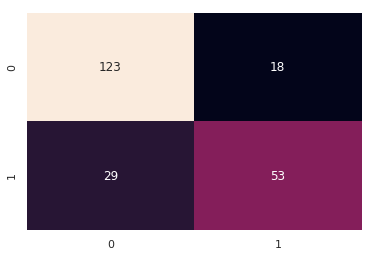

In [28]:
data = confusion_matrix(y_test,pred_rfc)

sns.set(style="darkgrid")
sns.heatmap(data,annot = True, fmt='g', cbar=False)

This is our base with Mean Accuracy Score of .78, 25 false positives and 24 false negatives. 

The next step is to do a very simple form of impudence and applying the mean value to missing data.

In [32]:
df_model = make_model_df(['Name','Ticket'])

In [33]:
df_model.Age.where(df_model.Age>0,np.NaN,inplace=True) 

At this point we finally get to use fancyimpute. We will be using the SimpleFill method first to impute the missing values with the mean of the column. SimpleFill can use other methods of simple imputation. It is called similarly to a model in scikit-learn with a fit_transform being applied to the dataset.

In [34]:
from fancyimpute import SimpleFill

In [35]:
fill = SimpleFill('mean',min_value=df_model.Age.min(),max_value=df_model.Age.max())

In [36]:
filled = fill.fit_transform(df_model)

In [37]:
df_model = pd.DataFrame(filled, columns=df_model.columns.values)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(df_model.drop("Survived",1),df_model.Survived, random_state = 42)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

rfc = RandomForestClassifier()

model=rfc.fit(X_train,y_train)
pred_rfc = rfc.predict(X_test)
pred_rfc_train = rfc.predict(X_train)
model.score(X_test,y_test)

0.7982062780269058

From model we see that our score has improved. Looking at the confusion matrix we see that our true negatives decreased while our true positives increased. Over all the result is about even.

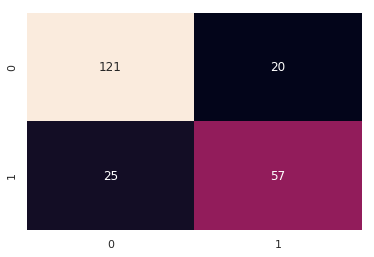

In [39]:
sns.set(style="darkgrid")
data = confusion_matrix(y_test,pred_rfc)
sns.heatmap(data,annot = True, fmt='g', cbar=False)

In [61]:
df_model = make_model_df(['Name','Ticket','known_age'])
df_model.Age.where(df_model.Age>0,np.NaN,inplace=True) 

The last thing we are going to do is to use the IterativeImputer. This is a package from MICE that fancyimpute brought over to python. Like the other methods this is implemented using scikit-learn fit_transform. I ran this and combined the results at the end. to get my results

In [62]:
from fancyimpute import IterativeImputer

In [63]:
def impute_data(df):
    fill = IterativeImputer(min_value=df.Age.min(),
                            max_value=df.Age.max(), 
                            sample_posterior=True,
                            random_state=42)
    filled = fill.fit_transform(df)
    df = pd.DataFrame(filled, columns=df.columns.values)
    #df_model.head(7)
    return df

In [65]:
def s_scale(df):
    X_train, X_test, y_train, y_test = train_test_split(df.drop("Survived",1),
                                                        df.Survived, 
                                                        random_state = 42)
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    return X_train, X_test, y_train, y_test

In [67]:
X_train, X_test, y_train, y_test = s_scale(df_0)
rfc0 = RandomForestClassifier()
model0=rfc0.fit(X_train,y_train)
pred_rfc.append(rfc0.predict(X_test))
model0.score(X_test,y_test)

0.7757847533632287

In [79]:
preds=[]
for i in range(len(pred_rfc[0])):
    #print(i)
    new_pred=0
    for j in range(len(pred_rfc)):
        new_pred +=pred_rfc[j][i]
    if new_pred>5:
        preds.append(1)
    elif new_pred<5:
        preds.append(0)
    else:
        preds.append(np.random.randint(0,2))
preds = np.array(preds)

We can see from the confusion matrix below our results did not improve substantially. That said this is a small dataset and the use of imputation cannot create data that isn't there.

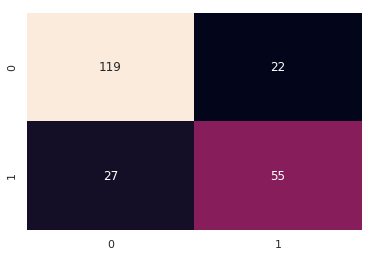

In [81]:
sns.set(style="darkgrid")
data = confusion_matrix(y_test,preds)
sns.heatmap(data,annot = True, fmt='g', cbar=False)

In the future I hope that packages such as fancyimpute will add packages that allow for testing of MCAR such as Little's test. I believe that using a larger data set would have more interesting result. All said, imputation is a tricky subject and will continue to be for the foreseeable future.